# Project 6 Example
### Alec K. Mattu (UTA)
### INST 414
### 12/07/2021

# Instructions
### Required
1. add your favorite song to the dataset as the last row. Manually enter the data entries of your favorite song (song name, artist name, year, and lyrics). 

2. Add a column  L which contains the number of words for each song, column V which contains the number of unique words for each song and column D containing the ratio V/L  (no scaling  needed).

3. Vectorize songs using tfidf vectorization. So now for each song there is a tfidf vector. Store in a dataframe called tfidf_vecs. 

4. Find the cosine similarity of your favorite song to every song in the dataset, using tfidf_vecs. 

5. Now add a column to the data called class. We want to label the song classes based on the similarity to your favorite song. Find the median of all cosine similarities and if the similarity of a song is above the median level, label it 1 and if the similarity is less than median level, label it 0.

6. Split the data to train and test set (0.25 of the rows in test set). Build a KNN classifier with this dataset, where features are year, L, V, and D and the output variable is class. Choose k=4 in this step. Print the accuracy to evaluate the performance of this classifier.

7. Now change k systematically (between 1 and 10) and build 100 classifiers for each k (split the data into training/test as before). Plot the accuracy on test test vs k and interpret the results in markdown cell.

8. Split the data to train and test set (0.25 of the rows in test set). Build a decision tree that uses entropy criterion. Do not change other default values. Print the accuracy of the classifier.

9. Repeat step8, but limit the depth of the tree to 3 levels.

10. Plot the tree. How many pure and impure leaves are in the tree? Interpret the difference between these leaves and their consequences in markdown cell.

### Bonus (3 points)
11. Choose a new song (not in your dataset) and find the features for this song. Do not calculate the cosine similarity for this song. It is supposed to be a new and unseen data point. We want to classify this song using the classifiers you built in this homework.

12. Choose one KNN and one decision tree classifier (the hyper-parameters are up to you). Find the predicted class of the new song by both classifiers. Are the predicted classes the same? How do you interpret the results? What does the class mean in this example? Do you find the predicted class(es) meaningful?

# Solution

## Part 0 - Preparation

In [1]:
# Import required libraries                                   # HOMEWORK USAGE
import csv                                                    # *Importing CSV
import pandas as pd                                           # General HW util
import numpy as np                                            # General util
import sklearn.metrics as metrics                             # LogisticRegression Metrics
import sklearn.feature_extraction                             # Song Lengths (L, V)
import matplotlib.pyplot as plt                               # General Graphing Util
import requests                                               # *Collecting Favorite Song
from bs4 import BeautifulSoup as bs                           # *Collecting Favorite Song
from sklearn.feature_extraction.text import TfidfVectorizer   # TF-IDF Vectorization
from sklearn.model_selection import train_test_split          # KNN Classification 
from sklearn.metrics import classification_report             # KNN Classification 
from sklearn.neighbors import KNeighborsClassifier            # KNN Classification
from sklearn import tree                                      # Entropy 

In [2]:
# Hold songs in a list
songs = []

# Open CSV file with handle
with open("dataset_out.csv") as csv_file:
    # Create a file reader
    file_reader = csv.DictReader(csv_file)
    
    # Loop through CSV rows
    for row in file_reader:
        songs.append(row)

In [3]:
df = pd.DataFrame(songs)

In [4]:
# Drop the unnamed first column
df.drop(df.columns[0], axis = 1, inplace = True, errors = 'ignore')
df["Year"] = pd.to_numeric(df["Year"], errors = 'coerce')
df.dropna(axis = 0, inplace = True)

# Drop normalized columns
df.drop(["normalized_L", "normalized_V", "normalized_D"], axis = 1, inplace = True, errors = 'ignore')

# Drop Z-Score columns
df.drop(["z_score_L", "z_score_V", "z_score_D"], axis = 1, inplace = True, errors = 'ignore')

# Drop L, V, D
df.drop(["L", "V", "D"], axis = 1, inplace = True, errors = 'ignore')

In [5]:
df

,Title,Artist,Year,Lyrics
0,the-battle,blood-sweat-tears,1970.0,While the king and queen lie sleeping\nAnd the...
1,hey-jude,count-basie,1970.0,"Hey Jude, don't make it bad\nTake a sad song a..."
2,time,david-bowie,1973.0,"Time, he's waiting in the wings\nHe speaks of ..."
3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972.0,"Birds flying high,\nIn search of a clear blue ..."
4,day-by-day,carmen-mcrae,1972.0,Day by day I'm falling more in love with you\n...
...,...,...,...,...
4495,the-dark-side-of-the-rainbow,da-grym-reefer,2012.0,Da Grym Reefer:\nI be sitting back\nThinking o...
4496,tester,anthrax,2006.0,"I've changed, by staying the same\nWhat does i..."
4497,killing-me-inside,crossfade,2011.0,There's a dream that comes to me\nAnd it whisp...
4498,babel,cruel-tie,2015.0,"I'm stepping down, hurrin' up. Settle down. Do..."


## Part 1 - Add Favorite Song
... a student may choose to order this differently

In [6]:
song = {
    'Title': 'taro',
    'Artist': 'alt-j',
    'Year': 2012,
    'Lyrics': "Indochina, Capa jumps Jeep, two feet creep up the road\nTo photo, to record meat lumps and war\nThey advance as does his chance, very yellow white flash\nA violent wrench grips mass, rips light, tears limbs like rags\nBurst so high finally Capa lands\nMine is a watery pit\nPainless with immense distance\nFrom medic from colleague, friend, enemy, foe\nHim five yards from his leg, from you, Taro\nDo not spray into eyes, I have sprayed you into my eyes\n3:10 PM, Capa pends death, quivers, last rattles, last chokes\nAll colors and cares glaze to gray, shriveled and stricken to dots\nThe left hand grasps what the body grasps not,\nLe photographe est mort\nThree, point, one, four, one, five, alive no longer my amour,\nFaded for home May of '54\nDoors open like arms my love,\nPainless with a great closeness\nTo Capa, to Capa, Capa dark after nothing, re-united with his leg and with you, Taro\nTaro\nDo not spray into eyes, I have sprayed you into my eyes\nHey Taro"
}

df.append(song, ignore_index = True)

,Title,Artist,Year,Lyrics
0,the-battle,blood-sweat-tears,1970.0,While the king and queen lie sleeping\nAnd the...
1,hey-jude,count-basie,1970.0,"Hey Jude, don't make it bad\nTake a sad song a..."
2,time,david-bowie,1973.0,"Time, he's waiting in the wings\nHe speaks of ..."
3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972.0,"Birds flying high,\nIn search of a clear blue ..."
4,day-by-day,carmen-mcrae,1972.0,Day by day I'm falling more in love with you\n...
...,...,...,...,...
4446,tester,anthrax,2006.0,"I've changed, by staying the same\nWhat does i..."
4447,killing-me-inside,crossfade,2011.0,There's a dream that comes to me\nAnd it whisp...
4448,babel,cruel-tie,2015.0,"I'm stepping down, hurrin' up. Settle down. Do..."
4449,i-know-i-ve-been-changed,aaron-neville,2010.0,"Oh I, know I've been changed\nAnd I know I've ..."


## Part 2 - Columns L, V, D

In [7]:
# (A) Generate the unique number of words for each song
# Instantiate the bag of words (Count Vectorizer)
bower = sklearn.feature_extraction.text.CountVectorizer(
    lowercase  = True,
    stop_words = "english"
)

# Form a matrix with Sklearn
matrix = bower.fit_transform(df["Lyrics"])
matrix_df = pd.DataFrame(matrix.toarray())

# Turn the matrix into a series (single column)
length_series = matrix_df.sum(axis = 1, skipna = True)

# Merge the new series into the existing DataFrame
df.drop('L', axis = 1, inplace = True, errors = 'ignore')
df = pd.merge(df, length_series.rename('L'), left_index = True, right_index = True)
df.head()

,Title,Artist,Year,Lyrics,L
0,the-battle,blood-sweat-tears,1970.0,While the king and queen lie sleeping\nAnd the...,103
1,hey-jude,count-basie,1970.0,"Hey Jude, don't make it bad\nTake a sad song a...",98
2,time,david-bowie,1973.0,"Time, he's waiting in the wings\nHe speaks of ...",197
3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972.0,"Birds flying high,\nIn search of a clear blue ...",43
4,day-by-day,carmen-mcrae,1972.0,Day by day I'm falling more in love with you\n...,29


In [8]:
# (B) Count only the unique values
# Instantiate the bag of words (Count Vectorizer)
bower = sklearn.feature_extraction.text.CountVectorizer(
    lowercase  = True,
    stop_words = "english"
)

# Form a matrix with Sklearn
matrix = bower.fit_transform(df["Lyrics"])
matrix_df = pd.DataFrame(matrix.toarray())

# Find word counts greater than 0
unique_words_series = matrix_df > 0

# Sum the NUMBER of columns with words occuring 1 or more times
unique_words_series = unique_words_series.sum(axis = 1, skipna = True)
unique_word_df = unique_words_series.to_frame();
unique_word_df.columns = ["V"]

# Merge the new series into the existing DataFrame
df.drop('V', axis = 1, inplace = True, errors = 'ignore')
df = pd.merge(df, unique_word_df, left_index = True, right_index = True)
df.head()

,Title,Artist,Year,Lyrics,L,V
0,the-battle,blood-sweat-tears,1970.0,While the king and queen lie sleeping\nAnd the...,103,70
1,hey-jude,count-basie,1970.0,"Hey Jude, don't make it bad\nTake a sad song a...",98,41
2,time,david-bowie,1973.0,"Time, he's waiting in the wings\nHe speaks of ...",197,74
3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972.0,"Birds flying high,\nIn search of a clear blue ...",43,38
4,day-by-day,carmen-mcrae,1972.0,Day by day I'm falling more in love with you\n...,29,19


In [9]:
# (C) Ratio of Unique-to-Total columns (V/L)
# Simply divide V (unique length) by L (total length)
df.drop('D', axis = 1, inplace = True, errors = 'ignore')
df["D"] = df["V"] / df["L"] 
df.head()

,Title,Artist,Year,Lyrics,L,V,D
0,the-battle,blood-sweat-tears,1970.0,While the king and queen lie sleeping\nAnd the...,103,70,0.679612
1,hey-jude,count-basie,1970.0,"Hey Jude, don't make it bad\nTake a sad song a...",98,41,0.418367
2,time,david-bowie,1973.0,"Time, he's waiting in the wings\nHe speaks of ...",197,74,0.375635
3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972.0,"Birds flying high,\nIn search of a clear blue ...",43,38,0.883721
4,day-by-day,carmen-mcrae,1972.0,Day by day I'm falling more in love with you\n...,29,19,0.655172


## Part 3 - TF-IDF Vectorization

In [10]:
# Vectorize lyrics with TF-IDF
bag_of_words = TfidfVectorizer(tokenizer = lambda txt: txt.split())
docterm = bag_of_words.fit_transform(df["Lyrics"])

# Add document terms to a DataFrame
tfidf_vecs = pd.DataFrame(docterm.toarray(), columns = bag_of_words.get_feature_names(), index = df["Title"])

In [11]:
tfidf_vecs

,!,"!!!""","""","""'cause","""....?""","""...and","""50","""?jacky?","""a","""a""",...,ïî­ïî¹,ïî±î¸îµî¯,ïïï,ïî­î¼î±,"ï,ïî¹",ïïî±î½,ïïî¹,öfter,über,überreden
Title,,,,,,,,,,,,,,,,,,,,,
the-battle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hey-jude,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
we-can-make-the-world-a-whole-lot-brighter,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
day-by-day,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
el-cuarto-de-tula,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hallelujah-i-love-her-so,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
human-inventions,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Part 4 - Cosine Similarity

In [12]:
# Reference "Favorite Song" Row
ref = tfidf_vecs.iloc[-1]

# Pull cosine similarities to ref song
cosines = pd.DataFrame(tfidf_vecs.dot(ref), index = df["Title"])
cosines.columns = ["CS"]

In [13]:
cosines

,CS
Title,
the-battle,0.150060
hey-jude,0.110253
time,0.016685
we-can-make-the-world-a-whole-lot-brighter,0.120667
day-by-day,0.099048
...,...
el-cuarto-de-tula,0.003077
hallelujah-i-love-her-so,0.121995
human-inventions,0.090194


## Part 5 - Class Column

In [14]:
# Medium cosine similarity
median = cosines["CS"].median() # Pandas.Series.median

median

0.12453996670036406

In [15]:
cosines.reset_index(drop = True, inplace = True) # Fix Indexing Error

# Merge DF + Cosine DF
df.drop('CS', axis = 1, inplace = True, errors = 'ignore')
df = pd.concat([df, cosines], axis = 1)
df.dropna(axis = 0, inplace = True)

In [16]:
df

,Title,Artist,Year,Lyrics,L,V,D,CS
0,the-battle,blood-sweat-tears,1970.0,While the king and queen lie sleeping\nAnd the...,103.0,70.0,0.679612,0.150060
1,hey-jude,count-basie,1970.0,"Hey Jude, don't make it bad\nTake a sad song a...",98.0,41.0,0.418367,0.110253
2,time,david-bowie,1973.0,"Time, he's waiting in the wings\nHe speaks of ...",197.0,74.0,0.375635,0.016685
3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972.0,"Birds flying high,\nIn search of a clear blue ...",43.0,38.0,0.883721,0.120667
4,day-by-day,carmen-mcrae,1972.0,Day by day I'm falling more in love with you\n...,29.0,19.0,0.655172,0.099048
...,...,...,...,...,...,...,...,...
4345,question,fish,2006.0,Why do we never get an answer\nWhen we`re knoc...,361.0,95.0,0.263158,0.003077
4346,high-cool,blur,2006.0,If you come here\nWhich sometimes do\nDon't th...,65.0,43.0,0.661538,0.121995
4347,da-dsferd,dimmu-borgir,2007.0,I det mrkeste mrke troner jeg\nI mine slaer tr...,46.0,41.0,0.891304,0.090194
4348,pale,ednaswap,2006.0,What to say\nThere is nothing I can do\nI cann...,234.0,154.0,0.658120,0.008469


In [17]:
# Default class to 0
df["Class"] = 0

# Assign 1 values
df.loc[df.CS > median, ['Class']] = 1

In [18]:
df

,Title,Artist,Year,Lyrics,L,V,D,CS,Class
0,the-battle,blood-sweat-tears,1970.0,While the king and queen lie sleeping\nAnd the...,103.0,70.0,0.679612,0.150060,1
1,hey-jude,count-basie,1970.0,"Hey Jude, don't make it bad\nTake a sad song a...",98.0,41.0,0.418367,0.110253,0
2,time,david-bowie,1973.0,"Time, he's waiting in the wings\nHe speaks of ...",197.0,74.0,0.375635,0.016685,0
3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972.0,"Birds flying high,\nIn search of a clear blue ...",43.0,38.0,0.883721,0.120667,0
4,day-by-day,carmen-mcrae,1972.0,Day by day I'm falling more in love with you\n...,29.0,19.0,0.655172,0.099048,0
...,...,...,...,...,...,...,...,...,...
4345,question,fish,2006.0,Why do we never get an answer\nWhen we`re knoc...,361.0,95.0,0.263158,0.003077,0
4346,high-cool,blur,2006.0,If you come here\nWhich sometimes do\nDon't th...,65.0,43.0,0.661538,0.121995,0
4347,da-dsferd,dimmu-borgir,2007.0,I det mrkeste mrke troner jeg\nI mine slaer tr...,46.0,41.0,0.891304,0.090194,0
4348,pale,ednaswap,2006.0,What to say\nThere is nothing I can do\nI cann...,234.0,154.0,0.658120,0.008469,0


## Part 6 - KNN Classifier w/ Test Train Split
Split the data to train and test set (0.25 of the rows in test set). Build a KNN classifier with this dataset, where features are year, L, V, and D and the output variable is class. Choose k=4 in this step. Print the accuracy to evaluate the performance of this classifier.

In [19]:
x = df[["Year", "L", "V", "D"]]
y = df["Class"]

In [20]:
# Define Data and Model
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25)
model = KNeighborsClassifier(n_neighbors = 4)

# Fit Model
model.fit(xtrain, ytrain)

# Predict Y points
y_pred = model.predict(xtest)

In [21]:
# Print model statistics
print(model.score(xtest, ytest))
print(classification_report(ytest, y_pred))

0.5702325581395349
              precision    recall  f1-score   support

           0       0.56      0.70      0.62       542
           1       0.59      0.44      0.50       533

    accuracy                           0.57      1075
   macro avg       0.57      0.57      0.56      1075
weighted avg       0.57      0.57      0.56      1075



## Part 7 - Increase Neighbors (1-10)

In [22]:
test_score = []
train_score = []

for K in np.arange(1, 10):
    testTemp = []
    trainTemp = []
    
    for j in np.arange(1, 5): # Supposed to be 1, 100
        xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25)
        model = KNeighborsClassifier(n_neighbors = K)
        model.fit(xtrain, ytrain)
        testTemp.append(model.score(xtest, ytest))
        trainTemp.append(model.score(xtrain, ytrain))        
        
    test_score.append(np.mean(testTemp))
    train_score.append(np.mean(trainTemp))

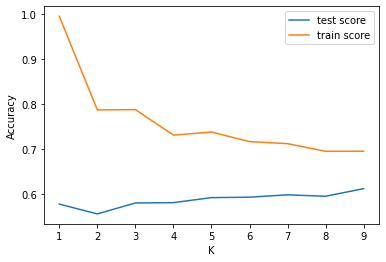

In [23]:
plt.plot(np.arange(1, 10),test_score,label="test score")
plt.plot(np.arange(1, 10),train_score,label="train score")
plt.xlabel("K")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Part 8 - Decision Tree with Entropy Criterion (2 Levels)

In [24]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25)

model = tree.DecisionTreeClassifier(max_depth = 2) 

model.fit(xtrain, ytrain)

print(model.score(xtest,ytest))

0.6186046511627907


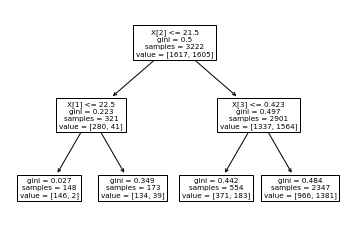

In [25]:
tree.plot_tree(model)

# Hide text
None

## Part 9 - Decision Tree Entropy (3 Levels)

In [26]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25)

model = tree.DecisionTreeClassifier(max_depth = 3) 

model.fit(xtrain, ytrain)

print(model.score(xtest,ytest))

0.6251162790697674


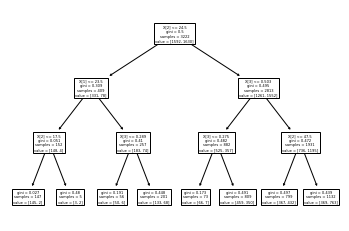

In [27]:
tree.plot_tree(model)

# Hide text
None

## Part 10 - Evaluate Above Trees
As a markdown cell, give a brief overview of:
- How many pure and impure leaves are in the tree?
- Interpret the difference between these leaves and their consequences

# Bonus Work (3pts)

## Part 11
Choose a new song (not in your dataset) and find the features for this song. Do not calculate the cosine similarity for this song. It is supposed to be a new and unseen data point. We want to classify this song using the classifiers you built in this homework.

## Part 12
Choose one KNN and one decision tree classifier (the hyper-parameters are up to you). Find the predicted class of the new song by both classifiers. Are the predicted classes the same? How do you interpret the results? What does the class mean in this example? Do you find the predicted class(es) meaningful?